# Longstaff-Schwartz Monte Carlo Algorithm
### Notebook & Python Implementation by
Michael Simmons

### Original Paper
https://people.math.ethz.ch/~hjfurrer/teaching/LongstaffSchwartzAmericanOptionsLeastSquareMonteCarlo.pdf

### Summary

This is a Python script that uses the Longstaff-Schwartz algorithm to price an American put option. The algoirthm is based on this paper: https://people.math.ethz.ch/~hjfurrer/teaching/LongstaffSchwartzAmericanOptionsLeastSquareMonteCarlo.pdf

Other sources were used to understand the math behind the algorithm, including Ito's Lemma and the Euler-Maruyama method.

### Other Resources Used
- Research: https://www.codearmo.com/blog/pricing-options-monte-carlo-simulation-python
- Ito's Lemma: https://en.wikipedia.org/wiki/Itô%27s_lemma
- Euler-Maruyama: https://en.wikipedia.org/wiki/Euler–Maruyama_method
- SDE Examples: https://ipython-books.github.io/134-simulating-a-stochastic-differential-equation/
- Root-mean-square error: https://en.wikipedia.org/wiki/Root-mean-square_deviation


### Code:

## Dependencies
For this script, the following libraries were used:

### Numpy
- Used for the linear algebra operations and more advanced math operations. Where possible, Numpy was used instead of Python's math library for efficiency.

### Random
- Required for simulating possible price paths, as well as illustrating the range of outcomes when graphed. Used to simulate Shochastic Differential Equations (SDEs)

### Matplotlib
- Used for graphing the possible price paths, as well as the option price at each time step.

### Scipy Stats
- Used in the graph for fitting the normal distribution to the terminal stock price distribution.

### JDC
- Used so that functions can be defined as a part of the main LSMonteCarlo class while being in a separate cell.


In [90]:
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.stats import norm
import jdc # Only if using a Jupyter notebook


### Create a class to implement the Longstaff-Schwartz algorithm
This will initialize the class with the required variables.

Here, the polynomial degree is 2, but can be changed to any degree. The higher the degree, the more accurate the regression will be, but the more computationally expensive it will be.



In [91]:
class LSMonteCarlo:
    def __init__(
            self,
            type,  # Types: Call, Put
            S_0,  # Initial Stock price (t=0)
            K,  # Strike price
            T,  # Time until expiration
            r,  # Risk-free rate
            q,  # Dividend yield
            volatility,  # Volatility
            period,  # Number of time steps (N)
            paths,  # Number of paths (M)
            polynomial_degree=2  # Degree of polynomial regression
    ):
        self.type = type
        self.S_0 = S_0
        self.K = K
        self.T = T
        self.r = r
        self.q = q
        self.volatility = volatility
        self.period = period
        self.paths = paths
        self.polynomial_degree = polynomial_degree
        self.deltaT = T / period
        self.discount = -r * self.deltaT  # Simulates the decay of the option value over time
        self.random_path()

### random_path function
Generate stock price paths using Geometric Brownian Motion (GBM).

Stochastic Differential Equation (SDE)
Under the risk-neutral measure $\mathbb{Q}$:
$$dS_t = (r-q)S_t dt + \sigma S_t dW_t$$
where:

$S_t$ is the stock price at time $t$
$r$ is the risk-free rate
$q$ is the dividend yield
$\sigma$ is the volatility
$W_t$ is a Wiener process

### Itô's Lemma
$$S_t = S_0 \exp\left((r-q-\frac{\sigma^2}{2})t + \sigma W_t\right)$$
### Discrete Form (Euler-Maruyama)
$$S_{t+\Delta t} = S_t \exp\left((r-q-\frac{\sigma^2}{2})\Delta t + \sigma\sqrt{\Delta t},\epsilon\right)$$
where $\epsilon \sim \mathcal{N}(0,1)$

For:
```
        self.randomWalk = np.zeros((self.paths, self.period + 1))
        self.randomWalk[:, 0] = self.S_0
```
This initializes the matrix of stock prices for each path and time step. The first column is the initial stock price.

For:
```
        for i in range(1, self.period + 1):
            # Implement Euler-Maruyama discretization of GBM
            self.randomWalk[:, i] = self.randomWalk[:, i - 1] * np.exp(
                (
                        self.r
                        - self.q
                        - (self.volatility ** 2) / 2
                )
                * self.deltaT
                + self.volatility
                * np.sqrt(self.deltaT)
                * np.random.normal(size=self.paths)  # Diffusion term
            )
```

This generates the stock price paths for each time step using the Euler-Maruyama method. The stock price at each time step is calculated using the previous stock price, the risk-free rate, the dividend yield, the volatility, and a random normal variable for the diffusion term.

This follows the discrete form for GBM:
$$S_{t+\Delta t} = S_t \exp\left((r-q-\frac{\sigma^2}{2})\Delta t + \sigma\sqrt{\Delta t},\epsilon\right)$$
where $\epsilon \sim \mathcal{N}(0,1)$






In [92]:
    %%add_to LSMonteCarlo
    def random_path(self):
        # Initialize price paths matrix S[m,n] for m paths and n time steps
        self.randomWalk = np.zeros((self.paths, self.period + 1))
        self.randomWalk[:, 0] = self.S_0

        # Generate paths following GBM using vectorized operations
        for i in range(1, self.period + 1):
            # Implement Euler-Maruyama discretization of GBM
            self.randomWalk[:, i] = self.randomWalk[:, i - 1] * np.exp(
                (
                        self.r
                        - self.q
                        - (self.volatility ** 2) / 2
                )
                * self.deltaT
                + self.volatility
                * np.sqrt(self.deltaT)
                * np.random.normal(size=self.paths)  # Diffusion term
            )


### pricing function
This function will price the option using the Longstaff-Schwartz algorithm (section 1 of the paper).

To do so, it will:
1. Generate paths using the random_path function and calculate the option's value if exercised at each time step.
2. For each possible exercise time before expiration, identify the ITM paths, regress the theta decay (discounted future value) on the basis functions, and compare the difference in values if exercises immediately or continued.

For Put options:
$$\text{Payoff (Put)} = \max(0, K - S_t)$$
For Call options:
$$\text{Payoff (Call)} = \max(0, S_t - K)$$

### Regression Formulas:
```regression = np.polyfit(self.randomWalk[hold, i], Y[hold], self.degree)
CV = np.polyval(regression, self.randomWalk[hold, i])
```

Implements:
$$E_t[V(t+1)] \approx \sum_{j=0}^n \beta_j X_t^j$$
Where $\beta_j$ are the coefficients of the polynomial regression and $X_t$ is the stock price at time $t$.

### Early Exercise:
The code
```
Y[hold] = np.where(
    self.payoff[hold, i] > CV,
    self.payoff[hold, i],
    Y[hold]
)
```
Implements:
$$\max{K - S_t, , E_t[V(t+1)]} \text{ for puts}$$
$$\max{S_t - K, , E_t[V(t+1)]} \text{ for calls}$$

### Final Price:
The code
```
self.Price = np.mean(Y)
self.std = np.std(Y) / np.sqrt(self.path)
self.rmsre = np.sqrt(np.mean(((Y - self.Price) / self.Price) ** 2))
```
Implements

- Option Price:
1. $$V_0 = \frac{1}{M}\sum_{i=1}^M Y_i$$
- Standard Error:
2. $$SE = \frac{\sigma}{\sqrt{M}}$$
- RMSRE (Root-mean-square relative error):
3. $$RMSRE = \sqrt{\frac{1}{M}\sum_{i=1}^M \left(\frac{Y_i - \hat{Y}}{Y_i}\right)^2}$$

In [93]:
    %%add_to LSMonteCarlo
    def pricing(self):
        # Calculate immediate exercise value at each time for all paths
        if self.type == "p":
            self.payoff = np.maximum(0, self.K - self.randomWalk)  # Put option payoff
        else:
            self.payoff = np.maximum(0, self.randomWalk - self.K)  # Call option payoff

        # Initialize with terminal payoff
        Y = self.randomWalk[:, -1]

        # Iterate backwards through exercise times
        for i in range(self.period - 2, -1, -1):
            # Discount future values
            Y *= np.exp(self.discount)

            # Identify in-the-money paths (Section 1, step 2)
            hold = np.where(self.payoff[:, i] > 0)

            if len(hold) > self.polynomial_degree:
                # Implement least squares regression (Section 1, step 3)
                # Regression estimates continuation value
                regression = np.polyfit(self.randomWalk[hold, i], Y[hold], self.polynomial_degree)
                CV = np.polyval(regression, self.randomWalk[hold, i])

                # Compare immediate exercise with continuation value (Section 1, step 4)
                Y[hold] = np.where(
                    self.payoff[hold, i] > CV,  # Exercise if immediate value > continuation
                    self.payoff[hold, i],  # Immediate exercise value
                    Y[hold]  # Hold value
                )

        # Calculate option value and error metrics
        self.price = np.mean(Y)  # Option value is average of optimal exercise values
        self.std = np.std(Y) / np.sqrt(self.paths)  # Standard error
        self.rmsre = np.sqrt(np.mean(((Y - self.price) / self.price) ** 2))  # Root-mean-square relative error

### plot function
Finally, to plot the results, Matplotlib is used:

Parameters:
- bin: number of bins for histogram
- sampling: number of paths to sample for trajectory plot
- style: visualization style ('default', 'dark', 'financial')
- figsize: tuple for figure size

In [94]:
    %%add_to LSMonteCarlo
    def plot(self, bin=50, sampling=50, figsize=(15, 10)):
        plt.style.use('dark_background')
        path_colors = plt.cm.plasma(np.linspace(0, 1, sampling))
        hist_color = 'white'
        fit_color = '#00ff00'

        # Figure and grid
        fig = plt.figure(figsize=figsize)
        gs = fig.add_gridspec(2, 2)

        # 1. Terminal Price Distribution (Top Left)
        ax1 = fig.add_subplot(gs[0, 0])
        n, x, patches = ax1.hist(self.randomWalk[:, -1], bins=bin,
                                 density=True, color=hist_color, alpha=0.7)

        # Add fitted curve
        mu, std = norm.fit(self.randomWalk[:, -1])
        xmin, xmax = ax1.get_xlim()
        x_fit = np.linspace(xmin, xmax, 100)
        p_fit = norm.pdf(x_fit, mu, std)
        ax1.plot(x_fit, p_fit, color=fit_color, linewidth=2,
                 label=f'Normal Fit\nμ={mu:.2f}, σ={std:.2f}')

        ax1.set_title('Terminal Stock Price Distribution')
        ax1.set_xlabel('Stock Price')
        ax1.set_ylabel('Density')
        ax1.legend()

        # 2. Price Path Evolution (Top Right)
        ax2 = fig.add_subplot(gs[0, 1])
        x = np.arange(0, self.period)
        sampled_paths = random.sample(range(self.paths), sampling)

        for idx, path in enumerate(sampled_paths):
            ax2.plot(x, self.randomWalk[path, :-1],
                     color=path_colors[idx], alpha=0.5, linewidth=1)

        ax2.set_title('Sample Stock Price Paths')
        ax2.set_xlabel('Time Step')
        ax2.set_ylabel('Stock Price')

        # 3. Price Path Heatmap (Bottom Left)
        ax3 = fig.add_subplot(gs[1, 0])
        sampled_paths_heatmap = self.randomWalk[sampled_paths, :-1].T
        im = ax3.imshow(sampled_paths_heatmap, aspect='auto', cmap='viridis')
        plt.colorbar(im, ax=ax3, label='Stock Price')
        ax3.set_title('Price Path Heatmap')
        ax3.set_xlabel('Path Number')
        ax3.set_ylabel('Time Step')

        # 4. Statistics Box (Bottom Right)
        ax4 = fig.add_subplot(gs[1, 1])
        ax4.axis('off')
        stats_text = (
            f'Option Statistics\n'
            f'----------------\n'
            f'Option Price: {self.price:.4f}\n'
            f'Standard Error: {self.std:.4f}\n'
            f'RMSRE: {self.rmsre:.4f}\n\n'
            f'Simulation Parameters\n'
            f'--------------------\n'
            f'Number of Paths: {self.paths}\n'
            f'Time Steps: {self.period}\n'
            f'Interest Rate: {self.r:.2%}\n'
            f'Volatility: {self.volatility:.2%}\n'
            f'Dividend Yield: {self.q:.2%}'
        )
        ax4.text(0.05, 0.95, stats_text,
                 transform=ax4.transAxes,
                 fontfamily='monospace',
                 verticalalignment='top',
                 fontsize=10)

        # Overall layout adjustments
        plt.tight_layout()
        plt.show()

### Example option

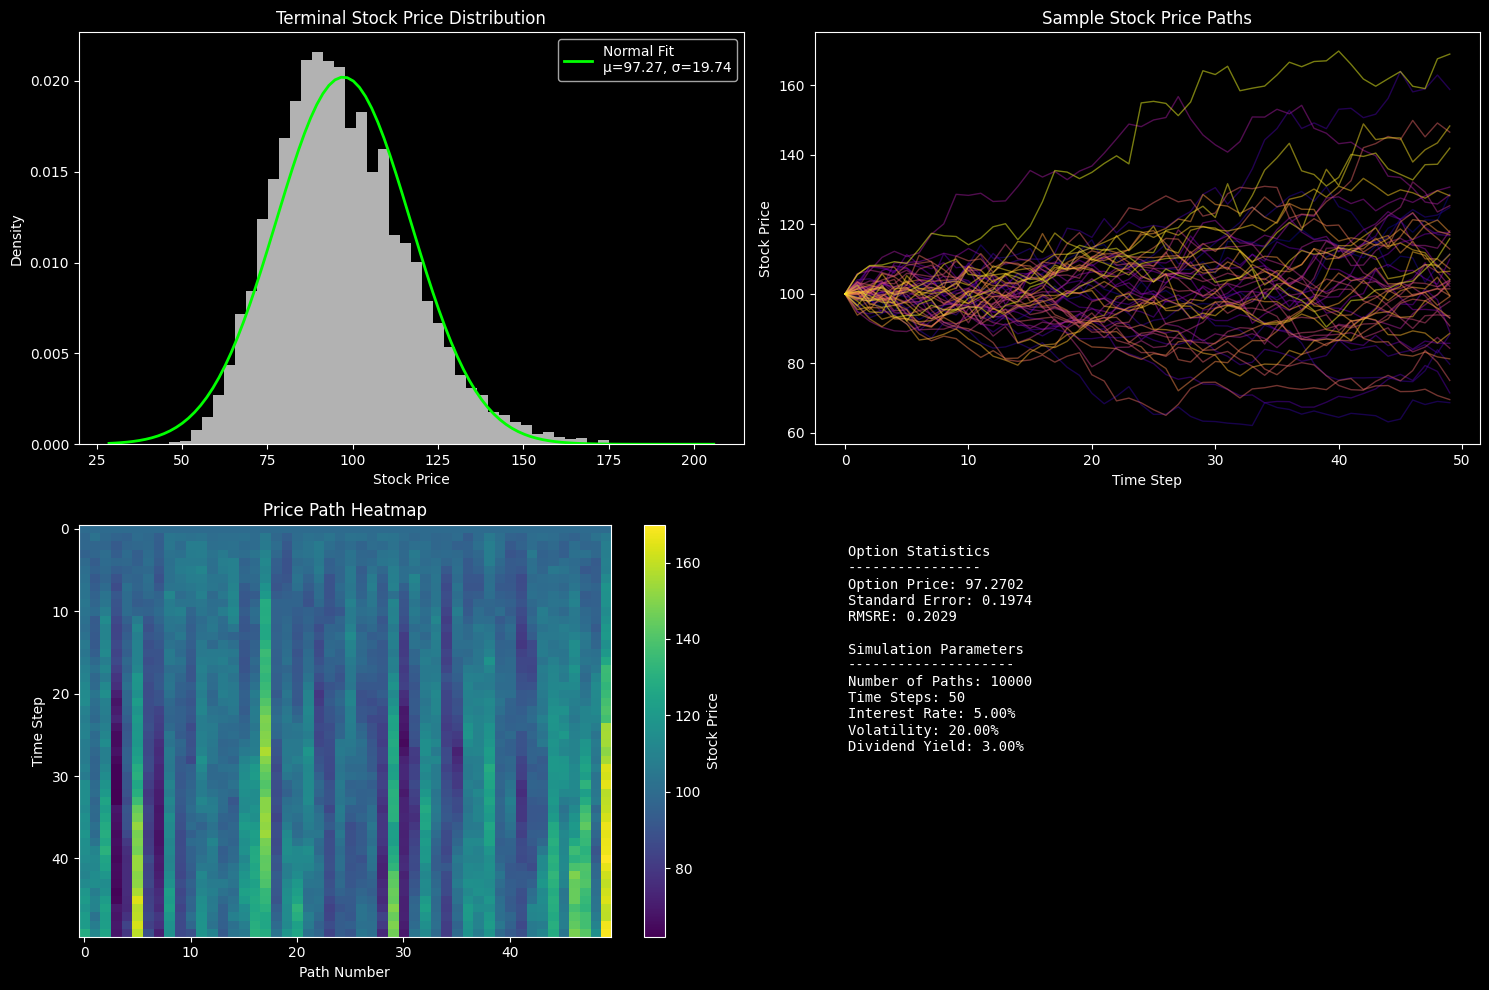

In [95]:
option = LSMonteCarlo("p", 100, 100, 1, 0.05, 0.03, 0.2, 50, 10000)
option.random_path()
option.pricing()
option.plot()
